# Data Processing 1.1 Training Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Class: 1_BMP2_SN_9563
>f4
(128, 128)
>f4
(128, 128)


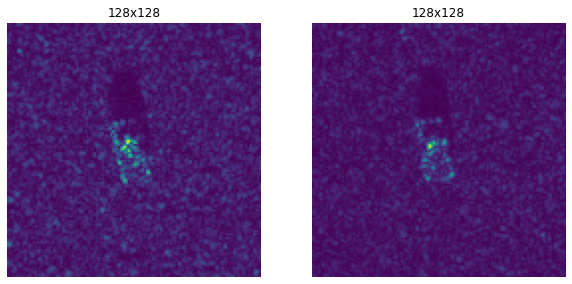

Class: 2_BRDM_2
>f4
(129, 128)
>f4
(129, 128)


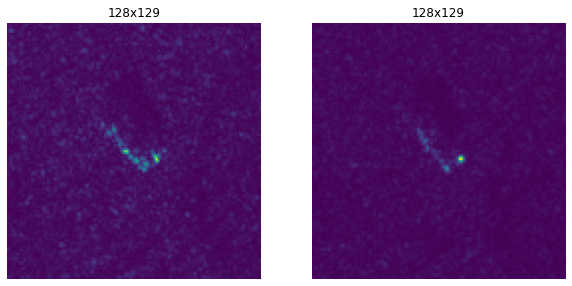

Class: 3_BTR70_SN_C71
>f4
(128, 128)
>f4
(128, 128)


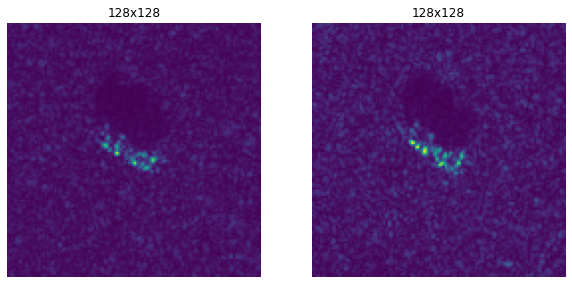

Class: 4_T72_SN_132
>f4
(128, 128)
>f4
(128, 128)


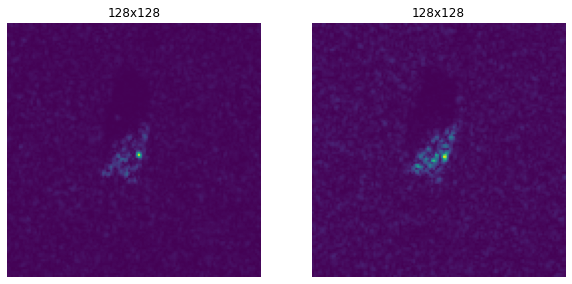

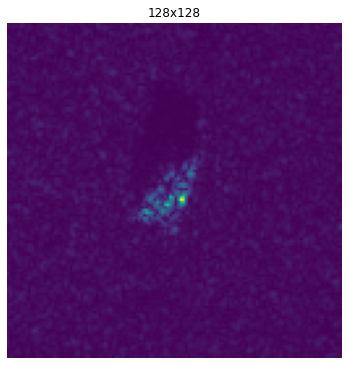

(88, 88)
float32


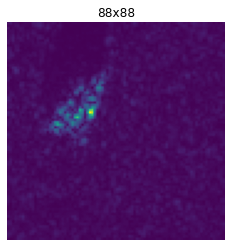

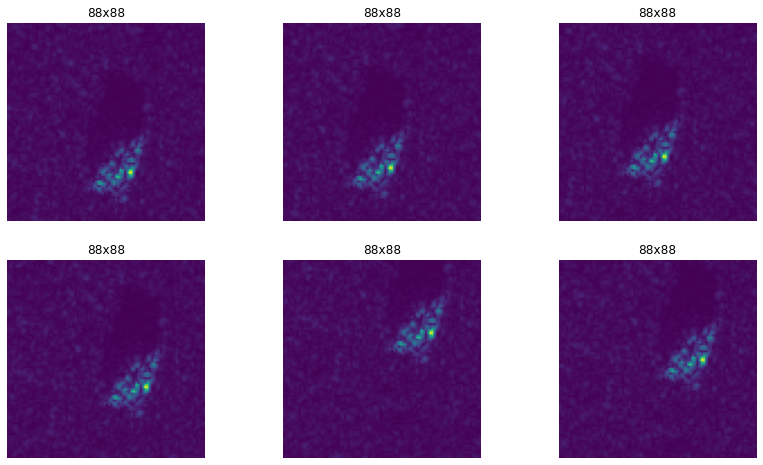

996
996
X_batch.shape (4, 88, 88, 1)
(88, 88, 1)


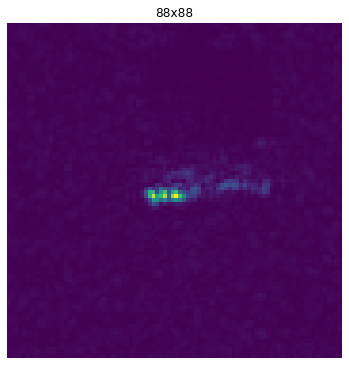

In [2]:
import numpy as np
import os
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt


FLOWERS_PATH = os.path.join("drive", "MyDrive", "Gwak_tf_ATR", "datasets")
flowers_root_path = os.path.join(FLOWERS_PATH, "traing_EOC2")
flower_classes = sorted([dirname for dirname in os.listdir(flowers_root_path)
                  if os.path.isdir(os.path.join(flowers_root_path, dirname))])

###############################################################################################################################
def readMSTAR(path):
    fid = open(path, 'rb')#열고(rb가 뭔지는 모르지만 b가 binary 의미?)
    
    hdr = str(fid.read())
    indx = hdr.find('PhoenixHeaderLength= ') + 21               #'PhoenixHeaderLength= ' is 21 characters
    hdr_length = int(hdr[indx:indx+hdr[indx:-1].find('\\n')])
    indx = hdr.find('native_header_length= ') + 22              #'native_header_length= ' is 22
    hdr_length = hdr_length + int(hdr[indx:indx+hdr[indx:-1].find('\\n')])
    indx = hdr.find('NumberOfColumns= ') + 17                   #'NumberOfColumns= ' is 17
    cols = int(hdr[indx:indx+hdr[indx:-1].find('\\n')])
    indx = hdr.find('NumberOfRows= ') + 14                      #'NumberOfColumns= ' is 14
    rows = int(hdr[indx:indx+hdr[indx:-1].find('\\n')])
    fid.close()
    #print(hdr_length)
    calib = 0
    fid = open(path,'rb')
    #print(hdr.rfind('TargetType= '))

    if  hdr.rfind('TargetType= ') == -1:    #Image is a clutter view
        fid.seek(hdr_length)
        img_mag = np.fromfile(fid, np.dtype('>u2'), rows*cols).reshape(rows,cols)
        
        indx = hdr.rfind('SensorCalibrationFactor= ') + 25
        calib = float(hdr[indx:indx+hdr[indx:-1].find('\n')])    
        img_mag = img_mag * calib/65536
        img_phase = np.fromfile(fid, np.dtype('>u2'), rows*cols).reshape(rows,cols)
        img_phase = img_phase * calib/65536
    
    else:                                   #Image is a Target view
        fid.seek(hdr_length)
        #print(fid.seek(hdr_length))
        #print(fid)
        img_mag = np.fromfile(fid, np.dtype('>f'),rows*cols).reshape(rows,cols)
        img_phase = np.fromfile(fid, np.dtype('>f'), rows*cols).reshape(rows,cols)
    
    fid.close()     
    return(img_mag)
###############################################################################################################################
from collections import defaultdict###여기서 각각의 class에 대한 image들의 directory를 얻는 것.

image_paths = defaultdict(list)
#print(image_paths)
for flower_class in flower_classes:
    image_dir = os.path.join(flowers_root_path, flower_class)
    #print(image_dir)
    for filepath in os.listdir(image_dir):
        #if filepath.endswith(".JPG"):
            #print(filepath)
        image_paths[flower_class].append(os.path.join(image_dir, filepath))
#print(image_paths)##image paths라고 하는 놈은 전체의 directory를 가지고 있다

for paths in image_paths.values():#정확히 어떻게 sort하는 지는 모르겟지만, 이렇게 해서 나눈다.
    paths.sort()    
###############################################################################################################################    
import matplotlib.image as mpimg

n_examples_per_class = 2

for flower_class in flower_classes:
    print("Class:", flower_class)#class: daisy(0)
    plt.figure(figsize=(10,5))#그림 size 조절(-)
    for index, example_image_path in enumerate(image_paths[flower_class][:n_examples_per_class]):#class마다 2개씩
        #example_image = mpimg.imread(example_image_path)
        example_image = readMSTAR(example_image_path)
        print(example_image.dtype)
        plt.subplot(100 + n_examples_per_class * 10 + index + 1)
        plt.title("{}x{}".format(example_image.shape[1], example_image.shape[0]))
        print(example_image.shape)#(imageshape : 158*158)
        plt.imshow(example_image)
        plt.axis("off")
    plt.show()
    
###############################################################################################################################
from skimage.transform import resize###image resize!!!!
def prepare_image(image, target_width = 88, target_height = 88):##88로 crop하기
    """NOT Zooms BUT crops the image randomly for data augmentation."""
    image = resize(image, (128, 128))#일단 128128로 imresize하고!
    
    # First, let's find the largest bounding box with the target size ratio that fits within the image
    height = image.shape[0]
    width = image.shape[1]
    
    x0 = np.random.randint(0, width - target_width)
    y0 = np.random.randint(0, height - target_height)
    #print('x0,y0:',x0,y0)
    x1 = x0 + target_width
    y1 = y0 + target_height
    
    # Let's crop the image using the random bounding box we built.
    image = image[y0:y1, x0:x1]
    
    # Finally, the Convolution Neural Network expects colors represented as
    # 32-bit floats ranging from 0.0 to 1.0:
    return image
###############################################################################################################################
plt.figure(figsize=(6, 8))
plt.imshow(example_image)
plt.title("{}x{}".format(example_image.shape[1], example_image.shape[0]))
plt.axis("off")
plt.show()

prepared_image = prepare_image(example_image)
print(prepared_image.shape)
print(prepared_image.dtype)
plt.figure(figsize=(4, 4))
plt.imshow(prepared_image)
plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
plt.axis("off")
plt.show()

rows, cols = 2, 3

plt.figure(figsize=(14, 8))
for row in range(rows):
    for col in range(cols):
        prepared_image = prepare_image(example_image)
        plt.subplot(rows, cols, row * cols + col + 1)
        plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
        plt.imshow(prepared_image)
        plt.axis("off")
plt.show()

###############################################################################################################################
flower_class_ids = {flower_class: index for index, flower_class in enumerate(flower_classes)}
flower_class_ids


flower_paths_and_classes = []
for flower_class, paths in image_paths.items():
    #print(flower_class,'\n',paths)
    for path in paths:
        #print(path)
        flower_paths_and_classes.append((path, flower_class_ids[flower_class]))
        
#print(flower_paths_and_classes)

test_ratio = 0.0
train_size = int(len(flower_paths_and_classes) * (1 - test_ratio))

print(len(flower_paths_and_classes))
print(train_size)

np.random.shuffle(flower_paths_and_classes)#무조건 shuffle해야 됨

flower_paths_and_classes_train = flower_paths_and_classes[:train_size]
#flower_paths_and_classes_test = flower_paths_and_classes[train_size:]
##이게 데이터 나누는것

flower_paths_and_classes_train[:3]###여기 train만 있다.
###############################################################################################################################
from random import sample

def prepare_batch(flower_paths_and_classes, batch_size):
    batch_paths_and_classes = sample(flower_paths_and_classes, batch_size)
    #images = [mpimg.imread(path)[:, :] for path, labels in batch_paths_and_classes]
    images = [readMSTAR(path)[:, :] for path, labels in batch_paths_and_classes]
    prepared_images = [prepare_image(image) for image in images]
    X_batch = np.stack(prepared_images)
    ##
    X_batch = X_batch.reshape(X_batch.shape[0],X_batch.shape[1],X_batch.shape[2],1)
    ## 흑백을 만들기 위해서 내가 추가한것(4D용)
    y_batch = np.array([labels for path, labels in batch_paths_and_classes], dtype=np.int32)
    ##
    
    ##one-hot으로 바꿔주기
    
    return X_batch, y_batch
###############################################################################################################################

X_batch, y_batch = prepare_batch(flower_paths_and_classes_train, batch_size=4)
print('X_batch.shape',X_batch.shape)

X_batch1= X_batch[1,:,:,:]
print(X_batch1.shape)
plt.figure(figsize=(6, 8))

X_batch1 = X_batch1.reshape(88,88)
plt.imshow(X_batch1)
plt.title("{}x{}".format(X_batch1.shape[1], X_batch1.shape[0]))
plt.axis("off")
plt.show()


In [3]:
np.random.rand()

0.07893758673724227

# Data Processing 1.2 Test Data

Class: 1_BMP
(128, 128)
(128, 128)


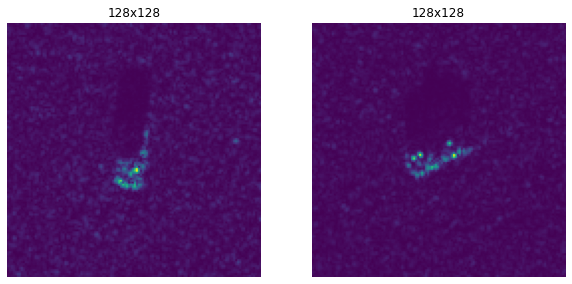

Class: 2_BRDM


<Figure size 720x360 with 0 Axes>

Class: 3_BTR


<Figure size 720x360 with 0 Axes>

Class: 4_T72
(128, 128)
(128, 128)


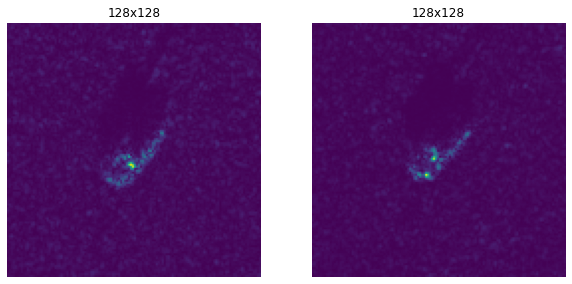

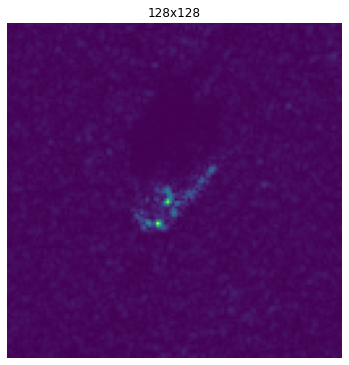

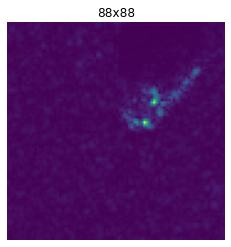

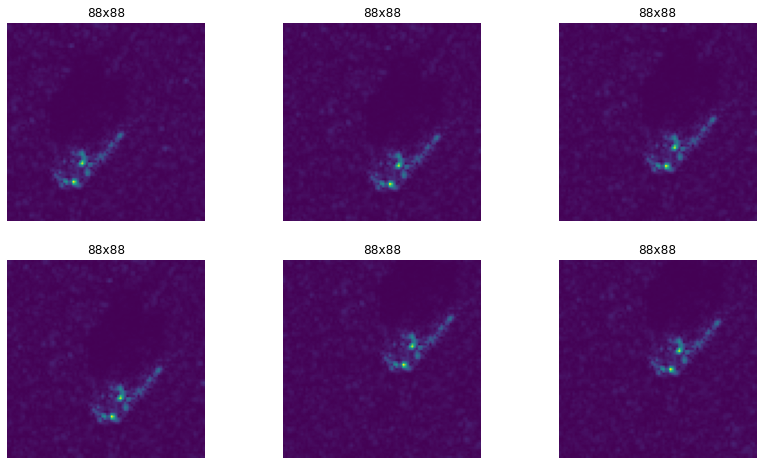

3569
0
X_batch.shape (4, 88, 88, 1)
(88, 88, 1)


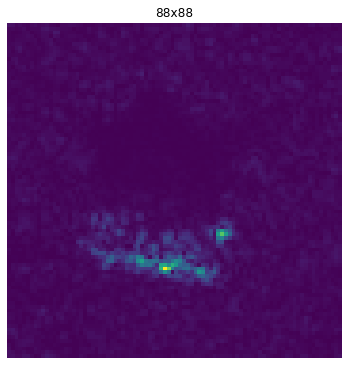

In [4]:
import numpy as np
import os
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt


FLOWERS_PATH = os.path.join("drive", "MyDrive", "Gwak_tf_ATR", "datasets")
flowers_root_path = os.path.join(FLOWERS_PATH, "test_EOC2_2_T72andBMP")
flower_classes = sorted([dirname for dirname in os.listdir(flowers_root_path)
                  if os.path.isdir(os.path.join(flowers_root_path, dirname))])


from collections import defaultdict###여기서 각각의 class에 대한 image들의 directory를 얻는 것.

image_paths = defaultdict(list)
#print(image_paths)
for flower_class in flower_classes:
    image_dir = os.path.join(flowers_root_path, flower_class)
    #print(image_dir)
    for filepath in os.listdir(image_dir):
        #if filepath.endswith(".JPG"):
            #print(filepath)
        image_paths[flower_class].append(os.path.join(image_dir, filepath))
#print(image_paths)##image paths라고 하는 놈은 전체의 directory를 가지고 있다

for paths in image_paths.values():#정확히 어떻게 sort하는 지는 모르겟지만, 이렇게 해서 나눈다.
    paths.sort()    
###############################################################################################################################    
import matplotlib.image as mpimg

n_examples_per_class = 2

for flower_class in flower_classes:
    print("Class:", flower_class)#class: daisy(0)
    plt.figure(figsize=(10,5))#그림 size 조절(-)
    for index, example_image_path in enumerate(image_paths[flower_class][:n_examples_per_class]):#class마다 2개씩
        #example_image = mpimg.imread(example_image_path)
        example_image = readMSTAR(example_image_path)
        plt.subplot(100 + n_examples_per_class * 10 + index + 1)
        plt.title("{}x{}".format(example_image.shape[1], example_image.shape[0]))
        print(example_image.shape)#(imageshape : 158*158)
        plt.imshow(example_image)
        plt.axis("off")
    plt.show()
###############################################################################################################################    
plt.figure(figsize=(6, 8))
plt.imshow(example_image)
plt.title("{}x{}".format(example_image.shape[1], example_image.shape[0]))
plt.axis("off")
plt.show()

prepared_image = prepare_image(example_image)

plt.figure(figsize=(4, 4))
plt.imshow(prepared_image)
plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
plt.axis("off")
plt.show()

rows, cols = 2, 3

plt.figure(figsize=(14, 8))
for row in range(rows):
    for col in range(cols):
        prepared_image = prepare_image(example_image)
        plt.subplot(rows, cols, row * cols + col + 1)
        plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
        plt.imshow(prepared_image)
        plt.axis("off")
plt.show()

###############################################################################################################################
flower_class_ids = {flower_class: index for index, flower_class in enumerate(flower_classes)}
flower_class_ids


flower_paths_and_classes = []
for flower_class, paths in image_paths.items():
    #print(flower_class,'\n',paths)
    for path in paths:
        #print(path)
        flower_paths_and_classes.append((path, flower_class_ids[flower_class]))
        
#print(flower_paths_and_classes)

test_ratio = 1.0
train_size = int(len(flower_paths_and_classes) * (1 - test_ratio))

print(len(flower_paths_and_classes))
print(train_size)

np.random.shuffle(flower_paths_and_classes)#무조건 shuffle해야 됨

#flower_paths_and_classes_train = flower_paths_and_classes[:train_size]
flower_paths_and_classes_test = flower_paths_and_classes[train_size:]
##이게 데이터 나누는것

flower_paths_and_classes_train[:3]###여기 train만 있다.
###############################################################################################################################
X_batch, y_batch = prepare_batch(flower_paths_and_classes_test, batch_size=4)
print('X_batch.shape',X_batch.shape)

X_batch1= X_batch[1,:,:,:]
print(X_batch1.shape)
plt.figure(figsize=(6, 8))

X_batch1 = X_batch1.reshape(88,88)
plt.imshow(X_batch1)
plt.title("{}x{}".format(X_batch1.shape[1], X_batch1.shape[0]))
plt.axis("off")
plt.show()


X_test, y_test = prepare_batch(flower_paths_and_classes_test, batch_size=len(flower_paths_and_classes_test))
#여기에는 test만 있다.

In [5]:
print(X_test.shape)

(3569, 88, 88, 1)


In [6]:
print(X_test.shape,y_test.shape)

(3569, 88, 88, 1) (3569,)


# Training 1.3

In [7]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow as tf2
import random
import matplotlib.pyplot as plt
tf2.random.set_seed(777)

Instructions for updating:
non-resource variables are not supported in the long term


In [8]:
# hyper parameters
learning_rate = 0.001#???
training_epochs = 100
batch_size = 100

n_iterations_per_epoch = len(flower_paths_and_classes_train) // batch_size
print(n_iterations_per_epoch)

# dropout (keep_prob) rate  0.7~0.5 on training, but should be 1 for testing
keep_prob = tf.placeholder(tf.float32)

9


In [9]:
with tf.name_scope("input"):
    X = tf.placeholder(tf.float32, [None,  88, 88, 1],name="X")
    X_img = X# img 88x88x1 (black/white)
    #Y = tf.placeholder(tf.float32, [None, 8])]
    #onehot모양이 아니라서
    y = tf.placeholder(tf.int32, shape=[None],name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')
    
conv1 = tf.layers.conv2d(X_img, filters=16, kernel_size=[5, 5],
                         strides=1, padding="VALID",use_bias=True,
                         bias_initializer=tf.zeros_initializer(),
                         activation=tf.nn.relu, name="conv1")

pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2],
                                            padding="SAME", strides=2, name="pool1")

conv2 = tf.layers.conv2d(pool1, filters=32, kernel_size=[5, 5],
                         strides=1, padding="VALID",use_bias=True,
                         bias_initializer=tf.zeros_initializer(),
                         activation=tf.nn.relu, name="conv2")

pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2],
                                            padding="SAME", strides=2, name="pool2")

conv3 = tf.layers.conv2d(pool2, filters=64, kernel_size=[6, 6],
                         strides=1, padding="VALID",use_bias=True,
                         bias_initializer=tf.zeros_initializer(),
                         activation=tf.nn.relu, name="conv3")

pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2],
                                            padding="SAME", strides=2, name="pool3")

#dropout3 = tf.layers.dropout(inputs=pool3,
#                                         rate=0.5, training=training)#추가

conv4 = tf.layers.conv2d(pool3, filters=128, kernel_size=[5, 5],
                         strides=1, padding="VALID",use_bias=True,
                         bias_initializer=tf.zeros_initializer(),
                         activation=tf.nn.relu, name="conv4")

dropout4 = tf.layers.dropout(inputs=conv4,
                                         rate=0.5, training=training)

conv5 = tf.layers.conv2d(dropout4, filters=4, kernel_size=[3, 3],
                         strides=1, padding="VALID",use_bias=True,
                         bias_initializer=tf.zeros_initializer(),
                         activation=None, name="conv5")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:575: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/pooling.py:600: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launche

In [10]:
#check layers
print(conv1)
print(conv2)
print(pool2)
print(conv3)
print(conv4)
print(conv5)

Tensor("conv1/Relu:0", shape=(?, 84, 84, 16), dtype=float32)
Tensor("conv2/Relu:0", shape=(?, 38, 38, 32), dtype=float32)
Tensor("pool2/MaxPool:0", shape=(?, 19, 19, 32), dtype=float32)
Tensor("conv3/Relu:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("conv4/Relu:0", shape=(?, 3, 3, 128), dtype=float32)
Tensor("conv5/BiasAdd:0", shape=(?, 1, 1, 4), dtype=float32)


In [11]:
logits=tf.reshape(conv5, [-1, 4])
flower_logits = logits
print(flower_logits)##마지막 logits은 one-hot으로 나온다. 이제 이것을 softmax로 나타낸다.
Y_proba = tf.nn.softmax(flower_logits, name="Y_proba")
print('Y_proba',Y_proba)

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=flower_logits, labels=y)
    print('logits,y',flower_logits,y)
    loss = tf.reduce_mean(xentropy)
    
    loss_summ = tf.summary.scalar("loss", loss)
    ##to use lose in tensorboard
    
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    #아래것은 momentum을 이용한 optimizer
    #optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momemtum = 0.9).minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(flower_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
    accuracy_summ = tf.summary.scalar("accuracy", accuracy)
    ##to see in tensorboard


with tf.name_scope("init_and_save"):
    #init = tf.global_variables_initializer()
    saver = tf.train.Saver()

Tensor("Reshape:0", shape=(?, 4), dtype=float32)
Y_proba Tensor("Y_proba:0", shape=(?, 4), dtype=float32)
logits,y Tensor("Reshape:0", shape=(?, 4), dtype=float32) Tensor("input/y:0", shape=(?,), dtype=int32)


In [12]:
print(flower_paths_and_classes_train) 

[('drive/MyDrive/Gwak_tf_ATR/datasets/traing_EOC2/1_BMP2_SN_9563/HB03823.000', 0), ('drive/MyDrive/Gwak_tf_ATR/datasets/traing_EOC2/1_BMP2_SN_9563/HB03908.000', 0), ('drive/MyDrive/Gwak_tf_ATR/datasets/traing_EOC2/3_BTR70_SN_C71/HB03875.004', 2), ('drive/MyDrive/Gwak_tf_ATR/datasets/traing_EOC2/3_BTR70_SN_C71/HB03844.004', 2), ('drive/MyDrive/Gwak_tf_ATR/datasets/traing_EOC2/4_T72_SN_132/HB04029.015', 3), ('drive/MyDrive/Gwak_tf_ATR/datasets/traing_EOC2/1_BMP2_SN_9563/HB03942.000', 0), ('drive/MyDrive/Gwak_tf_ATR/datasets/traing_EOC2/1_BMP2_SN_9563/HB03834.000', 0), ('drive/MyDrive/Gwak_tf_ATR/datasets/traing_EOC2/4_T72_SN_132/HB03807.015', 3), ('drive/MyDrive/Gwak_tf_ATR/datasets/traing_EOC2/4_T72_SN_132/HB03958.015', 3), ('drive/MyDrive/Gwak_tf_ATR/datasets/traing_EOC2/1_BMP2_SN_9563/HB03849.000', 0), ('drive/MyDrive/Gwak_tf_ATR/datasets/traing_EOC2/4_T72_SN_132/HB03892.015', 3), ('drive/MyDrive/Gwak_tf_ATR/datasets/traing_EOC2/1_BMP2_SN_9563/HB03879.000', 0), ('drive/MyDrive/Gwak_tf

In [13]:
print(flower_paths_and_classes_test)

[('drive/MyDrive/Gwak_tf_ATR/datasets/test_EOC2_2_T72andBMP/1_BMP/HB03928.002', 0), ('drive/MyDrive/Gwak_tf_ATR/datasets/test_EOC2_2_T72andBMP/1_BMP/HB03985.001', 0), ('drive/MyDrive/Gwak_tf_ATR/datasets/test_EOC2_2_T72andBMP/4_T72/HB19992.018', 3), ('drive/MyDrive/Gwak_tf_ATR/datasets/test_EOC2_2_T72andBMP/4_T72/HB19976.018', 3), ('drive/MyDrive/Gwak_tf_ATR/datasets/test_EOC2_2_T72andBMP/4_T72/HB19872.020', 3), ('drive/MyDrive/Gwak_tf_ATR/datasets/test_EOC2_2_T72andBMP/4_T72/HB19938.017', 3), ('drive/MyDrive/Gwak_tf_ATR/datasets/test_EOC2_2_T72andBMP/1_BMP/HB03353.002', 0), ('drive/MyDrive/Gwak_tf_ATR/datasets/test_EOC2_2_T72andBMP/1_BMP/HB03867.001', 0), ('drive/MyDrive/Gwak_tf_ATR/datasets/test_EOC2_2_T72andBMP/4_T72/HB15000.019', 3), ('drive/MyDrive/Gwak_tf_ATR/datasets/test_EOC2_2_T72andBMP/4_T72/HB20007.018', 3), ('drive/MyDrive/Gwak_tf_ATR/datasets/test_EOC2_2_T72andBMP/1_BMP/HB03341.001', 0), ('drive/MyDrive/Gwak_tf_ATR/datasets/test_EOC2_2_T72andBMP/4_T72/HB03446.016', 3), ('d

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/Gwak_tf_ATR/tmp/AconvNetEOC_220322_1.ckpt
Learning started. It takes sometime.
.........epoch 0  Train accur: 1.0 Test accur 0.96 cost 0.03461242156724135
.........epoch 1  Train accur: 1.0 Test accur 0.93 cost 0.06036999925143188
.........epoch 2  Train accur: 0.99 Test accur 0.73 cost 0.0593625261551804
.........epoch 3  Train accur: 0.99 Test accur 0.96 cost 0.04100229860179954
.........epoch 4  Train accur: 1.0 Test accur 0.89 cost 0.04271133937355545
.........epoch 5  Train accur: 0.97 Test accur 0.92 cost 0.08277516667213705
.........epoch 6  Train accur: 0.85 Test accur 0.83 cost 0.23061811323795053
.........epoch 7  Train accur: 0.98 Test accur 0.7 cost 0.1531249884929922
.........epoch 8  Train accur: 0.97 Test accur 0.83 cost 0.0928263929155138
.........epoch 9  Train accur: 0.99 Test accur 0.94 cost 0.06718145393662982
.........epoch 10  Train accur: 0.98 Test accur 0.82 cost 0.04391318538950549
.........epoch 

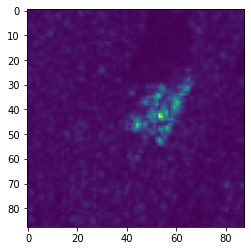

In [15]:
sess = tf.Session()

############################To see in tensorboard
merged_summary = tf.summary.merge_all()
writer = tf.summary.FileWriter("/content/drive/MyDrive/Gwak_tf_ATR/logs/AconvNet_bias_EOC2")
writer.add_graph(sess.graph)  # Show the graph
######################

sess.run(tf.global_variables_initializer())
saver.restore(sess, "/content/drive/MyDrive/Gwak_tf_ATR/tmp/AconvNetEOC_220322_1.ckpt")

# tensorboard --logdir=./logs/xor_logs


print('Learning started. It takes sometime.')
acc_before = 0.8

for epoch in range(training_epochs):
    avg_cost = 0

    for i in range(n_iterations_per_epoch):
        print(".", end="")    
        X_batch, y_batch = prepare_batch(flower_paths_and_classes_train, batch_size)
        X_batch_test, y_batch_test = prepare_batch(flower_paths_and_classes_test, batch_size)
               
        summary, c, _=sess.run([merged_summary, loss, optimizer], feed_dict={X: X_batch, y: y_batch, training : True}) #training이란 변수는 이전의 코드에서만 적용           
        #summary : to see in tensorboard
        writer.add_summary(summary, global_step=i)#to see in tensorboard
        
        avg_cost += c / n_iterations_per_epoch
    X_batch_test, y_batch_test = prepare_batch(flower_paths_and_classes_test, batch_size)
    acc_train = sess.run(accuracy, feed_dict={X: X_batch, y: y_batch})
    acc_test = sess.run(accuracy, feed_dict={X: X_batch_test, y: y_batch_test})

    if acc_test > acc_before:
            save_path = saver.save(sess, "/content/drive/MyDrive/Gwak_tf_ATR/tmp/AconvNetEOC_220322_2.ckpt")
            acc_before = acc_test
       
    print('epoch',epoch," Train accur:", acc_train, "Test accur", acc_test,'cost',avg_cost)
    
save_path = saver.save(sess, "/content/drive/MyDrive/Gwak_tf_ATR/tmp/AconvNetEOC_220322_fin2.ckpt")


print("Computing final accuracy on the test set (this will take a while)...")
acc_test = sess.run(accuracy, feed_dict={X: X_test, y: y_test})

print("Test accuracy:", acc_test)
print('Learning Finished!')

# Test model and check accuracy
r = random.randint(0, len(X_test) - 1)
print("Label: ", y_test[r])
print("Prediction: ", sess.run(tf.argmax(Y_proba, 1), feed_dict={X: X_test[r:r+1]}))

plt.imshow(X_test[r:r+1].
           reshape(88, 88))#, cmap='Greys', interpolation='nearest'
plt.show()
# if you have a OOM error, please refer to lab-11-X-mnist_deep_cnn_low_memory.py

In [ ]:
sess = tf.Session()

In [ ]:
saver = tf.train.Saver()

In [ ]:
saver.restore(sess, "./tmp/AconvNet_EOC1_30deg_final.ckpt")

INFO:tensorflow:Restoring parameters from ./tmp/my_model_final.ckpt


Label:  1
1045
[2 1 3 ..., 0 0 2]
Label:  1
(88, 88, 1)
(1, 88, 88, 1)


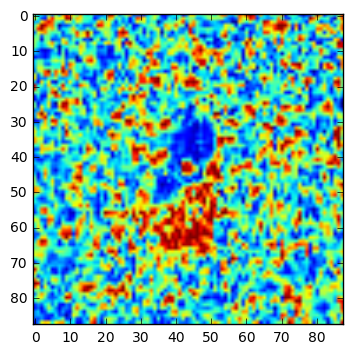

FailedPreconditionError: Attempting to use uninitialized value conv3/bias
	 [[Node: conv3/bias/read = Identity[T=DT_FLOAT, _class=["loc:@conv3/bias"], _device="/job:localhost/replica:0/task:0/cpu:0"](conv3/bias)]]

Caused by op 'conv3/bias/read', defined at:
  File "C:\Users\pilwonkwak\Anaconda3\lib\runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\pilwonkwak\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\pilwonkwak\Anaconda3\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Users\pilwonkwak\Anaconda3\lib\site-packages\traitlets\config\application.py", line 653, in launch_instance
    app.start()
  File "C:\Users\pilwonkwak\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\pilwonkwak\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\pilwonkwak\Anaconda3\lib\site-packages\tornado\ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "C:\Users\pilwonkwak\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\pilwonkwak\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\pilwonkwak\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\pilwonkwak\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\pilwonkwak\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\pilwonkwak\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\pilwonkwak\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\pilwonkwak\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\pilwonkwak\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\pilwonkwak\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\pilwonkwak\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\pilwonkwak\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\pilwonkwak\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-3ce2dc07bbd5>", line 28, in <module>
    activation=tf.nn.relu, name="conv3")
  File "C:\Users\pilwonkwak\Anaconda3\lib\site-packages\tensorflow\python\layers\convolutional.py", line 551, in conv2d
    return layer.apply(inputs)
  File "C:\Users\pilwonkwak\Anaconda3\lib\site-packages\tensorflow\python\layers\base.py", line 492, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "C:\Users\pilwonkwak\Anaconda3\lib\site-packages\tensorflow\python\layers\base.py", line 434, in __call__
    self.build(input_shapes[0])
  File "C:\Users\pilwonkwak\Anaconda3\lib\site-packages\tensorflow\python\layers\convolutional.py", line 144, in build
    dtype=self.dtype)
  File "C:\Users\pilwonkwak\Anaconda3\lib\site-packages\tensorflow\python\layers\base.py", line 374, in add_variable
    trainable=trainable and self.trainable)
  File "C:\Users\pilwonkwak\Anaconda3\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 1065, in get_variable
    use_resource=use_resource, custom_getter=custom_getter)
  File "C:\Users\pilwonkwak\Anaconda3\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 962, in get_variable
    use_resource=use_resource, custom_getter=custom_getter)
  File "C:\Users\pilwonkwak\Anaconda3\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 367, in get_variable
    validate_shape=validate_shape, use_resource=use_resource)
  File "C:\Users\pilwonkwak\Anaconda3\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 352, in _true_getter
    use_resource=use_resource)
  File "C:\Users\pilwonkwak\Anaconda3\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 725, in _get_single_variable
    validate_shape=validate_shape)
  File "C:\Users\pilwonkwak\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 200, in __init__
    expected_shape=expected_shape)
  File "C:\Users\pilwonkwak\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 319, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "C:\Users\pilwonkwak\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 1303, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "C:\Users\pilwonkwak\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "C:\Users\pilwonkwak\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\pilwonkwak\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value conv3/bias
	 [[Node: conv3/bias/read = Identity[T=DT_FLOAT, _class=["loc:@conv3/bias"], _device="/job:localhost/replica:0/task:0/cpu:0"](conv3/bias)]]


In [ ]:
# Test model and check accuracy
r = random.randint(0, len(X_test) - 1)
print("Label: ", y_test[r])
print(r)
print(y_test)
print("Label: ", y_test[r])
print(X_test[r,:,:,:].shape)
#print(X_test[r,:,:,:])
print(X_test[r:r+1].shape)
#print(X_test[r:r+1])
plt.imshow(X_test[r:r+1].
           reshape(88, 88))#, cmap='Greys', interpolation='nearest'
plt.show()
acc_test = sess.run(accuracy, feed_dict={X: X_test, y: y_test})

In [ ]:
print(acc_test)

0.980206
